In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import scipy

# location of files
loc = '/Users/laferrierek/Box Sync/Desktop/Research/Moon_C2/Codes/MGM/'

# save into array with same data shape
XY_shape = [50, 50] #np.shape(recalib[0, :, :])

# header: bands1 [0, 1, 2], band2 [3, 4, 5], band3 [6, 7, 8], continuum [9, 10, 11, 12], 
MGM_results = np.zeros((13, XY_shape[1], XY_shape[0]))


In [2]:
# Pick a pixel

X = 5 ; Y = 5


In [3]:
def cgauss(x0, width, zintens, x):
    """
    CGAUSS(X0, width, str, X) gives the gaussian distribution over the elements of X.
    X0 = gaussian center
    width = full-width half maximum
    zintens = strength or amplitude
    """
    
    xdif = x - x0           # Precalculated roots
    xsq = xdif * xdif
    sigsq = width
    
    c = zintens * np.exp(xsq/sigsq)
    
    return c #xdif, xsq, sigsq, c

def chpar(mstruc, datstruc):
    # subroutine to change cont, baseline, or band parameters
    """
    	ipmin,ipmax,ivtic   for  display
    	ihmin,ihmax,ihtic   for display
    	baseline constant
    	type of continuum   g gauss  p polynomial   n none  s straight line
           p0,p1,p2  for continuum
    	number of bands
    	center in nm   fwhm in inverse cm    intensity
    	center in nm   fwhm in inverse cm    intensity
    	center in nm   fwhm in inverse cm    intensity
    	etc
    
    """

    DoAgain = 1

    while DoAgain == 1:
        #itime = str(datetime.now())

        print('\n=====  Change MGM-Fit Parameters  =====\n')
        print('  Select:  1 - Change Continuum Type')
        print('           2 - Change Continuum Parameters')
        print('           3 - Change An Absorption')
        print('           4 - Add An Absorption')
        print('           5 - Delete An Absorption')
        print('           6 - Display')
        print('           7 - Main Menu   > ')

        choice = input(':  ')

        if len(choice) == 0:
            choice = '7'

        choice = int(choice)

        if choice == 1:
            # Change continuum type
            validcont = ['N', 'P', 'Q', 'G', 'S', 'T']
            print('\n')
            cont_typ = mstruc['contyp']

            if cont_typ == 'N':
                print(' No Continuum ')
            elif cont_typ == 'P':
                print(' Polynomial Continuum in Wavelength Space')
            elif cont_typ == 'Q':
                print(' Polynomial Continuum in Wavenumber Space')
            elif cont_typ == 'G':
                print(' Gaussian Continuum')
            elif cont_typ == 'S':
                print(f' Straight line removed in Wavelength {mstruc["swav1"]:.1f} - {mstruc["swav2"]:.1f}')
            elif cont_typ == 'T':
                print(f' Straight line removed in Wavenumber {mstruc["swav1"]:.1f} - {mstruc["swav2"]:.1f}')

            ans = input(' Enter new continuum type (N,P,Q,G,S,T): ').upper().strip()

            if len(ans) == 0:
                print('WARNING - Not a valid choice!')
            else:
                if ans in validcont:
                    mstruc['contyp'] = ans
                else:
                    print('WARNING - Not a valid choice!')

        elif choice == 2:
            # Change continuum parameters
            print(f' P0= {mstruc["cparam"][0]:.8e}  P1= {mstruc["cparam"][1]:.8e}  P2= {mstruc["cparam"][2]:.8e}  P3= {mstruc["cparam"][3]:.8e}')
            cont_typ = mstruc['contyp']

            if cont_typ == 'S' or cont_typ == 'T':
                p = [float(input(f'Enter continuum parameter P{i}: ')) for i in range(1, 5)]
                if cont_typ == 'S' and p[0] != 0:
                    mstruc['swav1'] = p[0]
                if cont_typ == 'S' and p[1] != 0:
                    mstruc['swav2'] = p[1]
                if cont_typ == 'T' and p[0] != 0:
                    mstruc['swav1'] = p[0]
                if cont_typ == 'T' and p[1] != 0:
                    mstruc['swav2'] = p[1]
            elif cont_typ == 'P' or cont_typ == 'Q':
                p = [float(input(f'Enter continuum parameter P{i}: ')) for i in range(1, 5)]
                if p[0] != 0:
                    mstruc['cparam'][0] = p[0]
                if p[1] != 0:
                    mstruc['cparam'][1] = p[1]
                if p[2] != 0:
                    mstruc['cparam'][2] = p[2]
                if p[3] != 0:
                    mstruc['cparam'][3] = p[3]

        elif choice == 3:
            # Change a band's parameters
            k = int(input(f' Which Absorption Band (0 - {mstruc["nbands"]-1}) ? '))
            if k >= 0 and k <= mstruc['nbands']:
                s1 = f'  {k}  Center= {mstruc["gcent"][k]:.8e}   '
                s2 = f'FWHM= {mstruc["gfwhm"][k]:.8e}   Str= {mstruc["gstr"][k]:.8e}'
                print(s1 + s2)
                names = ['Center  ', 'Width   ', 'Strength']
                p = [float(input(f'Enter band parameter- {names[kk]}: ')) for kk in range(3)]
                if p[0] != 0:
                    mstruc['gcent'][k] = p[0]
                if p[1] != 0:
                    mstruc['gfwhm'][k] = p[1]
                if p[2] != 0:
                    mstruc['gstr'][k] = p[2]

        elif choice == 4:
            # Add an absorption
            p0 = [float(input(' Enter Center in NM: ')), float(input(' Enter Center Uncertainty in NM: '))]
            p1 = [float(input(' Enter FWHM in NM: ')), float(input(' Enter FWHM Uncertainty in NM: '))]
            p2 = [float(input(' Enter Strength: ')), float(input(' Enter Strength Uncertainty: '))]

            mstruc = putin(mstruc, mstruc['nbands'] + 1, p0, p1, p2)

            datstruc['gauss'] = np.zeros((datstruc['npnts'], mstruc['nbands']))

        elif choice == 5:
            # Delete an absorption
            k = int(input(f' Which Absorption to delete (0 - {mstruc["nbands"] -1}) ? '))
            if k >= 0 and k <= mstruc['nbands']:
                s1 = f'  {k}  Center= {mstruc["gcent"][k]:.8e}   '
                s2 = f'FWHM= {mstruc["gfwhm"][k]:.8e}   Str= {mstruc["gstr"][k]:.8e}'
                print(s1 + s2)
                ans = input(' Delete This Absorption (y/n)? ').strip().upper()
                if ans == 'Y':
                    mstruc = takeout(mstruc, k)
                    datstruc['gauss'] = np.zeros((datstruc['npnts'], mstruc['nbands']))

        elif choice == 6:
            display_routine(mstruc, datstruc)

        elif choice == 7:
            DoAgain = 0

        print('\n')
        print('\n')

    return mstruc, datstruc


def recalculate(mstruc, datstruc):
    # Recalculate everything
    # Set clear polynomial parameters 
    
    contyp = mstruc['contyp']

    if contyp == 'S':
        npnts = datstruc['npnts']
        swav1 = mstruc['swav1']
        swav2 = mstruc['swav2']
        wavel = datstruc['wavel']
        ratio = datstruc['ratio']

        const, slope = tremove(npnts, swav1, swav2, wavel, ratio, 0)
        mstruc['cparam'] = [const, slope, 0., 0.]
    elif contyp == 'T':
        npnts = datstruc['npnts']
        swav1 = mstruc['swav1']
        swav2 = mstruc['swav2']
        waven = datstruc['waven']
        ratio = datstruc['ratio']

        const, slope = tremove(npnts, swav1, swav2, waven, ratio, 1)
        mstruc['cparam'] = [const, slope, 0., 0.]

    mstruc, datstruc = fillup(mstruc, datstruc)  # FILL UP THE ARRAYS

    return mstruc, datstruc

def putin(mstruc, nbands, p0, p1, p2):
    # Adding an absorbtion feature to model struc

    nparam = 3 * nbands + 4
    params = np.zeros(nparam)
    cmm = np.zeros(nparam)

    oldbands = mstruc['nbands']
    oldnparam = mstruc['nparam']

    # Fill in the values of the other parameters in the new arrays
    
    pdx = np.arange(1, 3 * nbands + 1).reshape(nbands, 3)
    odx = pdx[:oldbands, :]

    params[odx] = mstruc['params'][:oldnparam - 4]
    params[pdx[nbands - 1, :]] = [p0[0], p1[0], p2[0]]
    params[nparam - 4:nparam] = mstruc['params'][oldnparam - 4:oldnparam]

    cmm[odx] = mstruc['cmm'][:oldnparam - 4]
    cmm[pdx[nbands - 1, :]] = [p0[1], p1[1], p2[1]]
    cmm[nparam - 4:nparam] = mstruc['cmm'][oldnparam - 4:oldnparam]

    # Redefine model structure

    newroot = {'cnrt': np.zeros(nbands), 'sgsq': np.zeros(nbands)}

    mstruc['gcent'] = np.concatenate((mstruc['gcent'], [p0[0]]))
    mstruc['gfwhm'] = np.concatenate((mstruc['gfwhm'], [p1[0]]))
    mstruc['gstr'] = np.concatenate((mstruc['gstr'], [p2[0]]))
    mstruc['scent'] = np.concatenate((mstruc['scent'], [p0[1]]))
    mstruc['sfwhm'] = np.concatenate((mstruc['sfwhm'], [p1[1]]))
    mstruc['sstr'] = np.concatenate((mstruc['sstr'], [p2[1]]))
    mstruc['gcentn'] = np.concatenate((mstruc['gcentn'], [0.]))
    mstruc['gwidth'] = np.concatenate((mstruc['gwidth'], [0.]))
    mstruc['params'] = params
    mstruc['nparam'] = nparam
    mstruc['nbands'] = nbands
    mstruc['cmm'] = cmm
    mstruc['ipstat'] = np.zeros((nparam, 2))
    mstruc['roots'] = newroot

    ipstat = filstat(mstruc)
    mstruc['ipstat'] = ipstat

    return mstruc

def takeout(mstruc, nbands):
    # Taking out an absorbtion feature to model struc
    
    new_nbands = mstruc['nbands'] - 1
    pdx = np.arange(0, 3 * mstruc['nbands']).reshape(mstruc['nbands'], 3).T
    ngauss = np.arange(0, mstruc['nbands'])
    gdx = np.where(ngauss != nbands)[0]
    index = (pdx[gdx, :].T).reshape((6))

    params = np.zeros(3 * new_nbands + 4)
    params[:3 * new_nbands] = mstruc['params'][index] #np.asarray(mstruc['params'])[index].reshape((6))
    params[3 * new_nbands:] = mstruc['params'][mstruc['nparam'] - 4:mstruc['nparam']]

    cmm = np.zeros(3 * new_nbands + 4)
    cmm[:3 * new_nbands] = mstruc['cmm'][index]
    cmm[3 * new_nbands:] = mstruc['cmm'][mstruc['nparam'] - 4:mstruc['nparam']]

    # Redefine model structure
    newroot = {'cnrt': np.zeros(new_nbands), 'sgsq': np.zeros(new_nbands)}

    mstruc['gcent'] = mstruc['gcent'][gdx]
    mstruc['gfwhm'] = mstruc['gfwhm'][gdx]
    mstruc['gstr'] = mstruc['gstr'][gdx]
    mstruc['scent'] = mstruc['scent'][gdx]
    mstruc['sfwhm'] = mstruc['sfwhm'][gdx]
    mstruc['sstr'] = mstruc['sstr'][gdx]
    mstruc['gcentn'] = mstruc['gcentn'][gdx]
    mstruc['gwidth'] = mstruc['gwidth'][gdx]
    mstruc['params'] = params
    mstruc['nparam'] = len(params)
    mstruc['nbands'] = new_nbands
    mstruc['cmm'] = cmm
    mstruc['ipstat'] = np.zeros((mstruc['nparam'], 2))
    mstruc['roots'] = newroot

    ipstat = filstat(mstruc)
    mstruc['ipstat'] = ipstat

    return mstruc

def display_routine(mstruc, datstruc):
    # Graphics:
        
    idate = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    whichdata = [1, 2, 0, 4, 5, 0, 7]

    XTitle = 'Wavelength (In Microns)'
    value = datstruc['wavel'] / 1000.

    xdir = 0
    xtype = 0
    XR = [mstruc['XRange'][0:2], min(datstruc['waven'] / 1000.), max(datstruc['waven'] / 1000.)]
    YR = mstruc['YRange'][0:2]
    plot_it(mstruc, datstruc, whichdata, XTitle, value, xdir, xtype, XR, YR)

    YesDisplay = 1

    while YesDisplay == 1:
        #clc
        #yesps = 0

        print(f'{idate}   =====  MGM-FIT  Display Routines =====')
        print('   Select: 1-Display Graph in Wavelength Space')
        print('           2-Send to PDF')
        print('           3-Exit Display')

        choice = input(': ')
        if choice == '':
            choice = '7'

        choice = int(choice)

        if choice == 1:
            value = datstruc['wavel'] / 1000.
            XTitle = ' Wavelength ($\mu$m)'
            xdir = 0
            xtype = 0
            plt.show()
        elif choice == 2:
            #yesps = 1
            postfile = mstruc['DATfile'].replace('csv', 'png')
            plt.savefig(postfile, format='png', dpi=300)
        elif choice == 3:
            YesDisplay = 0

        if YesDisplay == 1:
            plot_it(mstruc, datstruc, whichdata, XTitle, value, xdir, xtype, XR, YR)

    return


def pgauss(x0, width, zintens, x, ipart):
    # subroutine to compute partial derivatives of gaussian
    
    """
    if ipart=1   derivative/center
    %	   ipart=2   derivative/width
    %	   ipart=3   derivative/intensity
    
    """
    
    xdif = x - x0           # supplied wave are x**(-2)
    xsq = xdif * xdif
    sigma = width
    sigsq = sigma * sigma


    # Evaulate partial derivative with respect to center
    if ipart == 1:
        pg = (xdif / sigsq) * (-1.0 * x0**2.0) / 1.0E7
        
    # Evaluate partial derivative with respect to width
    elif ipart == 2:
        pg = xsq / (sigsq * sigma)
        
        
    # evaluate partial derivative with respect to strength
    elif ipart == 3:
        pg = 1.0 / zintens
    else:
        raise ValueError('No such partial derivative!')
    
    return pg

def rmserr(arr1, arr2):
    # Calculate the root mean square error between two arrays
    dif = arr1 - arr2
    sqr = dif * dif
    tot = np.sum(sqr) / len(arr1)
    r = np.sqrt(tot)
    return r

def spit_it_out(mstruc, rmscur, ppp, inparam, G):
    finalfile = mstruc['FITfile'].replace('.fit', '_fin.fit')

    with open(finalfile, 'wt') as lun2:
        lun2.write(f'{mstruc["DATDir"]}\n')
        lun2.write(f'{mstruc["DFile"]}\n')
        lun2.write(f'{mstruc["YRange"][0] * 1000 / 10},{mstruc["YRange"][1] * 100},{mstruc["YRange"][2] * 100}\n')
        lun2.write(f'{mstruc["XRange"][0] * 1000},{mstruc["XRange"][1] * 1000},{mstruc["XRange"][2] * 1000}\n')
        lun2.write(f'{mstruc["rmslim"]},{mstruc["rimplim"]:0.3E}\n')
        lun2.write(f'{mstruc["contyp"]}\n')

        gtginv = np.linalg.inv(np.dot(G.T, G))
        mstruc['std'][ppp] = 1.96 * np.sqrt(np.diag(gtginv) * rmscur**2)

        if mstruc['contyp'] != 'N':
            ndx = np.where(mstruc['cparam'] != 0)
            ncpar = len(ndx[0])
            uncert = mstruc['std'][inparam - ncpar + 1:inparam]
            if ncpar < 4:
                uncert = np.append(uncert, np.zeros(4 - ncpar))
            lun2.write(f'  {" ".join([f"{val:15.6E}" for val in mstruc["cparam"]])}\n')
            lun2.write(f'  {mstruc["cparam"][0]:8.3f}    {" ".join([f"{val:15.2E}" for val in uncert])}\n')

        lun2.write(f'{mstruc["nbands"]:2d}\n')

        wconst = 2.354820
        uncert = mstruc['std'][:mstruc['nbands']]
        temp = np.ones(mstruc['nbands'])
        cntmax = temp / (temp / mstruc['gcent'] - uncert * 1E-7)
        cntmin = temp / (temp / mstruc['gcent'] + uncert * 1E-7)
        uncert = cntmax - cntmin

        for k in range(mstruc['nbands']):
            lun2.write(f'   {mstruc["gcent"][k]:15.6e}{mstruc["gfwhm"][k]:15.6e}{mstruc["gstr"][k]:15.6e}\n')
            lun2.write(f'        {uncert[k]:8.4f}      {mstruc["std"][mstruc["nbands"] + k] * wconst:8.4f}      {mstruc["std"][2 * mstruc["nbands"] + k]:8.4f}\n')

    return 


def storcurv1(mstruc, datstruc):
    # Store stuff in reflectance format
    itime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    print(' ')
    print(' ')
    print(f'{itime}  ======  Reflectance Storage Routines  ======')

    head = input('  Enter Header for Data Files: ')

    # File #1: Individual Bands...
    file = head + 'BNDS'
    writegauss(datstruc['wavel'], 
               np.exp(datstruc['gauss']), 
               file, 
               mstruc['gcent'], 
               mstruc['gfwhm'], 
               np.exp(mstruc['gstr']))

    # File #2: Everything else...
    npnts = datstruc['npnts']

    EXT = '.asc'
    filout = head + 'DATA' + EXT

    with open(filout, 'wt') as lun:
        lun.write(f'%% File created: {itime}\n')
        lun.write('%%\n')
        lun.write('%% Columns = (1) Wave, (2) Refl  (3) Fit,  (4) Continuum\n')
        lun.write('%%           (5) Cmb. Bands, (6) Resid, (7) Spec-Cont.\n')
        lun.write('%%\n')

        for k in range(npnts):
            rtemp = np.exp(datstruc['ratio'][k]) - np.exp(datstruc['fit'][k])
            lun.write('%12.6f%12.6f%12.6f%12.6f%12.6f%12.6f%12.6f\n' % (
                datstruc['wavel'][k],
                np.exp(datstruc['ratio'][k]),
                np.exp(datstruc['fit'][k]),
                np.exp(datstruc['cont'][k]),
                np.exp(datstruc['gline'][k]),
                rtemp,
                np.exp(datstruc['rcont'][k])))

    print(f'Data saved to {filout}')
    return


def storcurv2(mstruc, datstruc):
    # Store stuff in log base e
    itime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    print(' ')
    print(' ')
    print(f'{itime}  ======  Log Base e Storage Routines  ======')

    head = input('  Enter Header for Data Files: ')

    # File #1: Individual Bands...
    file = head + 'LBNDS'
    writegauss(datstruc['wavel'], datstruc['gauss'], file, mstruc['gcent'], mstruc['gfwhm'], mstruc['gstr'])

    # File #2: Everything else...
    npnts = datstruc['npnts']

    EXT = '.asc'
    filout = head + 'LDATA' + EXT

    with open(filout, 'wt') as lun:
        lun.write(f'%% File created: {itime}\n')
        lun.write('%%\n')
        lun.write('%%                 *** Log Base e Format ****\n')
        lun.write('%% Columns = (1) Wave, (2) Log Refl  (3) Fit,  (4) Continuum\n')
        lun.write('%%           (5) Cmb. Bands, (6) Resid, (7) Spec-Cont.\n')
        lun.write('%%\n')

        for k in range(npnts):
            rtemp = datstruc['ratio'][k] - datstruc['fit'][k]
            lun.write('%12.6f%12.6f%12.6f%12.6f%12.6f%12.6f%12.6f\n' % (
                datstruc['wavel'][k], datstruc['ratio'][k], datstruc['fit'][k],
                datstruc['cont'][k], datstruc['gline'][k], rtemp, datstruc['rcont'][k]))

    print(f'Data saved to {filout}')
    return


def tremove(NPNTS, WAVS, WAVF, WAVIN, RATIO, whichtype):
    # Program computes a straight line at desired wavenumbers or wavelengths
    # fit the two pits closest to wav1, wav2
    
    if whichtype == 1:
        WAVA = wltown(WAVS)
        WAVB = wltown(WAVF)  # Convert nm to wavenumber
    else:
        WAVA = WAVS
        WAVB = WAVF

    IP1 = np.argmax(WAVIN >= WAVA)
    IP2 = np.argmax(WAVIN >= WAVB)

    RAT1 = (RATIO[IP1 - 1] + RATIO[IP1] + RATIO[IP1 + 1]) / 3.0
    RAT2 = (RATIO[IP2 - 1] + RATIO[IP2] + RATIO[IP2 + 1]) / 3.0
    WAV1 = WAVIN[IP1]
    WAV2 = WAVIN[IP2]
    SLOPE = (RAT2 - RAT1) / (WAV2 - WAV1)  # Calculate slope
    C1 = RAT1 - (SLOPE * WAV1)  # Calculate intercept
    C2 = RAT2 - (SLOPE * WAV2)
    CONST = (C1 + C2) / 2.0

    return CONST, SLOPE

def unshuffl(mstruc):
    # put param array back to individual gaussian arrays
    
    wconst = mstruc['wconst']

    # Unshuffle the parameters
    for k in range(mstruc['nbands']):
        mstruc['gcentn'][k] = mstruc['params'][k]
        mstruc['gwidth'][k] = mstruc['params'][mstruc['nbands'] + k]
        mstruc['gfwhm'][k] = mstruc['gwidth'][k] * wconst
        mstruc['gstr'][k] = mstruc['params'][mstruc['nbands'] + mstruc['nbands'] + k]

        mstruc['gcent'][k] = wntowl(mstruc['gcentn'][k])

    # Unstore the cont/baseline params
    mstruc['cparam'] = mstruc['params'][mstruc['nparam'] - 4 : mstruc['nparam']]
    return mstruc

def wltown(wavel):
    # Function to convert wavelength in nm to wavenumber in inverse cm
    return 1.0E7 / wavel

def wntowl(waven):
    # Function to convert wavenumber in inverse cm to wavelength in nm
    return 1.0E7 / waven

def writegauss(wavin, ratin, file, p1, p2, p3):
    npnts = len(wavin)
    nbands = len(p1)

    ext = '.asc'
    filout = file + ext

    itime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    with open(filout, 'wt') as lun:
        lun.write(f'%% File created: {itime}\n')
        lun.write('%%\n')
        lun.write('%% Absorption Bands with\n')

        cform = ' ' * 6
        for k in range(nbands):
            cform += '%12.4f'
        cform += '\n'

        cform1 = '%% Center = ' + cform
        lun.write(cform1 % tuple(p1))

        cform1 = '%% FWHM   = ' + cform
        lun.write(cform1 % tuple(p2))

        cform1 = '%% Str    = ' + cform
        lun.write(cform1 % tuple(p3))
        lun.write('%\n')

        cform = ' ' * 6
        for k in range(nbands + 1):
            cform += '%15.6e'
        cform += '\n'

        for k in range(npnts):
            gband = ratin[k, :]
            lun.write(cform % (wavin[k], *gband))
            
def fillup(mstruc, datstruc):
    # subroutine to fill all the GFIT arrays

    wconst = mstruc['wconst']
    params, mstruc, datstruc = shuffl(mstruc, datstruc)

    # then build the individual bands
    gauss = np.zeros((datstruc['npnts'], mstruc['nbands']))

    for K in range(0, mstruc['nbands']):
        gauss[:, K] = cgauss(mstruc['roots']['cnrt'][K], mstruc['roots']['sgsq'][K], mstruc['gstr'][K], datstruc['wvrt'])
    
    # calculate the sum of the bands
    gline = np.sum(gauss, axis=1)

    # set clear continuum polynomioal parameters
    switch_contyp = {
        'P': 'wavel', # polynomial in wavelength
        'Q': 'waven', # polynomial in wavenumber
        'S': 'wavel', # straight line removal in wavelength
        'T': 'waven', # straight line removal in wavenumber
    }

    if mstruc['contyp'] in switch_contyp:
        w = datstruc[switch_contyp[mstruc['contyp']]]
        ws = w * w
        wc = w * ws

        cont = (
            mstruc['cparam'][0]
            + (mstruc['cparam'][1] * w)
            + (mstruc['cparam'][2] * ws)
            + (mstruc['cparam'][3] * wc)
        )

        cont = np.log(cont)
    else:
        cont = np.zeros(datstruc['npnts']) # no continuum

    # calculate fit line
    fit = cont + gline
    
    # calcilate residual and remain
    resid = datstruc['ratio'] - fit
    rcont = datstruc['ratio'] - cont

    datstruc['gline'] = gline
    datstruc['cont'] = cont
    datstruc['gauss'] = gauss
    datstruc['fit'] = fit
    datstruc['resid'] = resid
    datstruc['rcont'] = rcont
    mstruc['params'] = params

    return mstruc, datstruc

def shuffl(mstruc, datstruc):
    # subroutine to fill the param array
    wconst = mstruc['wconst']

    # Convert wavlength to wavenumber and FWHM to width
    ndx = np.nonzero(datstruc['waven'])[0]
    datstruc['wvrt'][ndx] = (1.0 / datstruc['waven'][ndx]) * 1e7

    mstruc['gcentn'] = wltown(mstruc['gcent'])  # Convert to wavenumber
    mstruc['gwidth'] = mstruc['gfwhm'] / wconst

    ndx = np.nonzero(mstruc['gcentn'])[0]
    mstruc['roots']['cnrt'][ndx] = (1.0/mstruc['gcentn'][ndx])*1e7

    SGRT = mstruc['gwidth']  # To be determined
    mstruc['roots']['sgsq'] = (SGRT * SGRT) * (-2.0)  # -2.0 * SIGMA SQUARED

    # Fill the param array
    #	1-nbands ARE CENTERS
    #	nbands+1 - 2nbands ARE WIDTHS
    #	2nbands+1 - 3bands ARE STRENGTHS
    nbands = mstruc['nbands']
    nparam = 3 * nbands + 4
    params = np.zeros((nparam))

    for K in range(1, nbands + 1):
        params[K - 1] = mstruc['gcentn'][K - 1]
        params[nbands + K - 1] = mstruc['gwidth'][K - 1]
        params[nbands + nbands + K - 1] = mstruc['gstr'][K - 1]

    # Store the cont/baseline params
    params[nparam - 4 : nparam] = mstruc['cparam']

    mstruc['PARAM0'] = params  # Store the original parameters

    return params, mstruc, datstruc

def dumpar(mstruc, datstruc):
    
    # list all parameters to FOR004.dat
    
    """
    %	ipmin,ipmax,ivtic   for  display
    %	ihmin,ihmax,ihtic   for display
    %	baseline constant
    %	type of continuum   g gaussians  p polynomial   n none  s straight line
    %       p0,p1,p2  for continuum
    %	number of bands
    %	center in nm   fwhm in inverse cm    intensity
    %	center in nm   fwhm in inverse cm    intensity
    %	center in nm   fwhm in inverse cm    intensity
    %	etc
    %
    """
    
    outfile1 = 'dump_FOR004.dat'
    lun = open(outfile1, 'wt')

    idate = np.datetime64('now')
    itime = str(idate)
    lun.write(f'{idate}   =====  MGM-Fit Parameters  =====   {itime}\n\n')

    # Baseline continuum list
    if mstruc['contyp'] == 'N':
        lun.write(' No Continuum \n\n')
    elif mstruc['contyp'] == 'P':
        lun.write(' Polynomial Continuum in Wavelength Space\n\n')
    elif mstruc['contyp'] == 'Q':
        lun.write(' Polynomial Continuum in Wavenumber Space\n\n')
    elif mstruc['contyp'] == 'G':
        lun.write(' Gaussian Continuum\n\n')
    elif mstruc['contyp'] == 'S':
        lun.write(f' Straight line removed in Wavelength {mstruc["swav1"]:.1f} {mstruc["swav2"]:.1f}\n\n')
    elif mstruc['contyp'] == 'T':
        lun.write(f' Straight line removed in Wavenumber {mstruc["swav1"]:.1f} {mstruc["swav2"]:.1f}\n\n')
    else:
        lun.write('\n\n')

    if mstruc['contyp'] != 'N':
        lun.write(f'   {mstruc["cparam"][0]:.7e}   {mstruc["cparam"][1]:.7e}   {mstruc["cparam"][2]:.7e}   {mstruc["cparam"][3]:.7e}\n\n')

    lun.write(f'                    {mstruc["nbands"]}  Absorption Bands\n')

    OFORM = '  #        Center             FWHM          Strength          Log Area\n'
    lun.write(OFORM)

    gsum = np.sum(datstruc['gauss'], axis=0)

    for k in range(mstruc['nbands']):
        lun.write(f'{k + 1:3d}   {mstruc["gcent"][k]:15.8e}   {mstruc["gfwhm"][k]:15.8e}   {mstruc["gstr"][k]:15.8e}   {gsum[k]:15.8e}\n')

    # write error
    rmscur = rmserr(datstruc['fit'], datstruc['ratio'])
    lun.write(f'\n {rmscur:.6e} = Current RMS Error\n')

    rmscur = np.sqrt((rmscur**2) * datstruc['npnts'] / (datstruc['npnts'] - (mstruc['nparam'] - 4)))

    lun.close()
    
    # write out for009 with 2 sigma range of parameters
    outfile2 = 'dump_FOR009.dat'
    lun2 = open(outfile2, 'wt')
    lun2.write('     MGM_Ver 2 --- 2 Sigma (95 perc. confidence) Model Parameters\n\n')
    
    # baseline continuum list

    if mstruc['contyp'] != 'N':
        ndx = np.where(mstruc['cparam'] == 0)[0]
        ncnt = len(ndx)
        inparam = mstruc['nparam'] - ncnt
        if mstruc['contyp'] != 'N':
            ndx = np.where(mstruc['cparam'] != 0)[0]
            ncpar = len(ndx)
            clow = mstruc['cparam'][ndx] - mstruc['std'][inparam - ncpar:inparam]
            chigh = mstruc['cparam'][ndx] + mstruc['std'][inparam - ncpar:inparam]

            for k in range(ncpar):
                lun2.write(f'  {clow[k]:.2e} < P{ndx[k] + 1} < {chigh[k]:.2e}\n')

            uncert = mstruc['std'][inparam - ncpar:inparam]
            if ncpar < 4:
                uncert = np.append(uncert, np.zeros(4 - ncpar))
    
    lun2.write(f'\n{mstruc["nbands"]} Absorption Bands\n\n')

    # now list bands ...
    wconst = 2.354820
    uncert = mstruc['std'][:mstruc['nbands']]
    temp = np.ones(mstruc['nbands'])
    cntmax = temp / (temp / mstruc['gcent'] - uncert * 1E-7)
    cntmin = temp / (temp / mstruc['gcent'] + uncert * 1E-7)
    gform = '%3i%10.3f <c<%10.3f  %10.3f <w<%10.3f %10.3f <s<%10.3f\n'

    for k in range(mstruc['nbands']):
        lun2.write(gform % (k + 1, cntmin[k], cntmax[k],
                            mstruc['gfwhm'][k] - mstruc['std'][mstruc['nbands'] + k],
                            mstruc['std'][mstruc['nbands'] + k] + mstruc['gfwhm'][k],
                            mstruc['gstr'][k] - mstruc['std'][2 * mstruc['nbands'] + k],
                            mstruc['std'][2 * mstruc['nbands'] + k] + mstruc['gstr'][k]))

    lun2.close()
    return 

#%% Make Plots

def plot_it(mstruc, datstruc, whichdata, XTitle, value, xdir, xtype, XR, YR):
    idate = str(np.datetime64('now'))
    color_arr = ['#bfd3e6', '#9ebcda','#8c96c6','#8856a7','#c51b8a']
    
    fig = plt.figure(figsize=(6, 6), dpi=200, layout="constrained")
    ax = fig.subplot_mosaic(
        [
            ["a"],
            ["c"]
        ],
        height_ratios=[3, 1], 
    )    
    
    plt.title(str(idate)+ "-" +str(mstruc['DATfile']))
    plt.xlabel(XTitle)
    plt.ylabel('Natural Log Reflectance')
    
    # wavelength
    xvalue = datstruc['wavel']/1000
    
    # continuum
    continuum = datstruc['cont']
    
    # Continuum Fit and individual bands
    ax["a"].plot(xvalue, datstruc['ratio']-continuum, c='k', linewidth=2, label='Ratio')
    ax["a"].plot(xvalue, datstruc['gline'], c=color_arr[-1], linewidth=2, label='Comb. Bands')
    for i in range(np.shape(datstruc['gauss'][0, :])[0]):
        ax["a"].plot(xvalue, datstruc['gauss'][:, i], c=color_arr[i], linestyle='dashed', label='Band:%2.0f'%i)

    lines = ax["a"].get_lines()
    legend1 = ax["a"].legend(lines[2:], ["Band 1", "Band 2", "Band 3"], loc='lower right')
    ax["a"].legend(lines[0:2], ["Ratio", "Combined Bands"], loc='lower left')
    ax["a"].add_artist(legend1)

    miny = 1.1*np.nanmin(datstruc['gline'])
    maxy = 1.1*np.nanmax(datstruc['ratio'])
    ax["a"].set_yticks(np.arange(-0.1, 0.1, 0.01))
    ax["a"].set_yticks(np.arange(-0.1, 0.1, 0.002), minor=True)
    ax["a"].set_xticks(np.arange(1.0, 2.7, 0.25))
    ax["a"].set_xticks(np.arange(1.0, 2.7, 0.05), minor=True)
    ax["a"].set_xlim((1.47, 2.63))
    ax["a"].set_ylim((miny, maxy))
    ax["a"].set_xlabel(XTitle)
    ax["a"].set_ylabel('Natural Log Reflectance')

    # Residual
    maxy = np.nanmax(np.abs(datstruc['resid'])) 
    ax["c"].plot(xvalue, datstruc['resid'])
    ax["c"].hlines(0, 5, 0, colors='k', linestyle='dashed')
    ax["c"].set_yticks(np.arange(-maxy, maxy+1, 2*maxy/5))
    ax["c"].set_yticks(np.arange(-maxy, maxy+1, 2*maxy/20), minor=True)
    ax["c"].set_xticks(np.arange(1.0, 2.7, 0.25))
    ax["c"].set_xticks(np.arange(1.0, 2.7, 0.05), minor=True)
    ax["c"].set_xlim((1.47, 2.63))
    ax["c"].set_ylim((-maxy, maxy))
    ax["c"].set_xlabel(XTitle)
    ax["c"].set_ylabel('Residual')
    
    if xdir == 1:
        plt.gca().invert_xaxis()

    #plt.show()
   
    return 

#%% Below is copied from matlab directly, untested

def filstat(mstruc):
    # fill ipstat with derivate types
    """
    %	FILL THE TYPE PARTIAL DERIVATIVE ARRAY
    %
    %	1-nbands ARE CENTERS
    %	nbands+1 - 2nbands ARE WIDTHS
    %	2nbands+1 - 3bands ARE STRENGTHS
    %
    """
    
    
    nbands = mstruc['nbands']
    nparam = 3 * nbands + 4
    ipstat = np.zeros((nparam, 2))

    for K in range(1, nbands + 1):
        ipstat[K - 1, 1] = 1
        ipstat[nbands + K - 1, 1] = 2
        ipstat[nbands + nbands + K - 1, 1] = 3

    ipstat[nparam - 4 : nparam, 1] = [4, 5, 6, 7]  # CONSTANT, X, X*X, X*X*X

    return ipstat

def get_data(datarr, nbands):
    # Read in data file
    #datarr = np.loadtxt(DatFile)
    sz = datarr.shape

    errors = 'n'

    if sz[1] > 2:
        print(' ')
        errors = input(' Use Errorbars (y or n) ?   ').lower()
    
    if errors == 'y':
        daterror = datarr[:, 2]
    else:
        daterror = np.ones(sz[0])

    ratio = np.log(datarr[:, 1])  # Convert to log reflectance

    wavel = datarr[:, 0]  # Input data in Nanometers
    waven = wltown(wavel)  # Convert to wavenumber

    # Create data structure
    npnts = len(ratio)

    datstruc = {
        'ratio': ratio,
        'wavel': wavel,
        'waven': waven,
        'daterror': daterror,
        'wvrt': np.zeros(npnts),
        'fit': np.zeros(npnts),
        'cont': np.zeros(npnts),
        'resid': np.zeros(npnts),
        'rcont': np.zeros(npnts),
        'remain': np.zeros(npnts),
        'gline': np.zeros(npnts),
        'gauss': np.zeros((npnts, nbands)),
        'npnts': npnts
    }

    return datstruc


#%%

def get_model(FitFile):
    # subroutine to get initial data for gfit
    # routine reads in initial file, parameters from startup with extension .fit
    
    # Constants
    wconst = 2.354820

    # Suppress warning
    #np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

    # Read in the model info from the FitFile
    mstruc = read_fitfile(FitFile)
    nbands = mstruc['nbands']
    nparam = mstruc['nparam']  # 3 params/gaussian + 4 for continuum

    # Initialize parameters
    cmm = np.zeros(nparam)

    mstruc['scent'] = wltown(mstruc['gcent'] - mstruc['scent']) - wltown(mstruc['gcent'] + mstruc['scent'])
    mstruc['sfwhm'] = mstruc['sfwhm'] / wconst

    # Fill the param array
    for k in range(1, nbands + 1):
        cmm[k - 1] = mstruc['scent'][k - 1]
        cmm[nbands + k - 1] = mstruc['sfwhm'][k - 1]
        cmm[2 * nbands + k - 1] = mstruc['sstr'][k - 1]

    cmm[nparam - 4:nparam] = mstruc['sparam']
    mstruc['cmm'] = cmm

    ipstat = filstat(mstruc)  # Fill in the types of partials
    ipstat[:, 0] = 0  # Unlock all parameters
    mstruc['ipstat'] = ipstat

    return mstruc

#%%
def listpar(mstruc, datstruc):
    # list all parameters to the screen
    """
    %	ipmin,ipmax,ivtic   for  display
    %	ihmin,ihmax,ihtic   for display
    %	baseline constant
    %	type of continuum   g gaussain  p polynomial   n none  s straight line
    %       p0,p1,p2  for continuum
    %	number of gaussians
    %	center in nm   fwhm in inverse cm    intensity
    %	center in nm   fwhm in inverse cm    intensity
    %	center in nm   fwhm in inverse cm    intensity
    %	etc
    %
    %	clc
    """
    idate = np.datetime64('now')

    print(f'{idate}   =====  MGM-Fit Parameters  =====\n')

    # Now dump out the current parameters

    # Baseline continuum list
    if mstruc['contyp'] == 'N':
        print(' No Continuum\n')
    elif mstruc['contyp'] == 'P':
        print(' Polynomial Continuum in Wavelength Space\n')
    elif mstruc['contyp'] == 'Q':
        print(' Polynomial Continuum in Wavenumber Space\n')
    elif mstruc['contyp'] == 'G':
        print(' Gaussian Continuum\n')
    elif mstruc['contyp'] == 'S':
        print(f" Straight line removed in Wavelength {mstruc['swav1']} {mstruc['swav2']}\n")
    elif mstruc['contyp'] == 'T':
        print(f" Straight line removed in Wavenumber {mstruc['swav1']} {mstruc['swav2']}\n")

    if mstruc['contyp'] != 'N':
        print(f" P0= {mstruc['cparam'][0]:14.7e}  P1= {mstruc['cparam'][1]:14.7e}  P2= {mstruc['cparam'][2]:14.7e}  P3= {mstruc['cparam'][3]:14.7e}\n")

    # now list bands
    print(f'{mstruc["nbands"]} Absorption Bands\n')

    for k in range(1, mstruc['nbands'] + 1):
        print(f'{k:2}  Center= {mstruc["gcent"][k - 1]:15.8e}   FWHM= {mstruc["gfwhm"][k - 1]:15.8e}   Str= {mstruc["gstr"][k - 1]:15.8e}')

    # Write error
    rmscur = rmserr(datstruc['fit'], datstruc['ratio'])

    print('\n')
    print(f' Current RMS Error {rmscur:12.6e}')

    input(':')
    return 

#%%

def liststat(mstruc):
    # list locked/unlocked status of all parameters
    """
    %	ipmin,ipmax,ivtic   for  display
    %	ihmin,ihmax,ihtic   for display
    %	baseline constant
    %	type of continuum   g gaussian  p polynomial   n none  s straight line
    %       p0,p1,p2  for continuum
    %	number of bands
    %	center in nm   fwhm in inverse cm    intensity
    %	center in nm   fwhm in inverse cm    intensity
    %	center in nm   fwhm in inverse cm    intensity
    %	etc
    %
    %	clc
    """
    idate = np.datetime64('now')

    print(f'{idate}     =====  Parameter Status  =====')

    # Now dump out the current parameters

    # Now list bands
    print('\n                             Absorption Bands')
    print('    #            Center         FWHM            Strength')

    setpar = [['Unlocked'] * 3 for _ in range(mstruc['nbands'])]
    pdx = np.reshape(np.arange(0, 3*mstruc['nbands']), (3,3)).T

    for k in range(0, mstruc['nbands']):
        ndx = np.where(mstruc['ipstat'][pdx[k, :], 0]==1)[0]
        for i in ndx:
            setpar[k][i] = 'Locked'

        tmp = ["".join(setpar[k])]
        value = "\t".join(tmp)

        print(f'  {k:3} +           {value}')

    print('\n')
    
    # Write error
    if mstruc['contyp'] != 'N':
        setpar = ['Unlocked'] * 4
        ndx = [i for i, val in enumerate(mstruc['ipstat'][mstruc['nparam'] - 4:mstruc['nparam'], 0]) if val]
        for i in ndx:
            setpar[i] = ' Locked '

        s = 'Continuum Parameters' + '          C0           C1              C2              C3'
        print(s)

        tmp = "".join(setpar)
        value = "\t".join(tmp)

        print(f'                           {value}')

    input(':')
    return 

#%%
def lockup(mstruc):
    # lock/unlock parameters
    """
    %	ipmin,ipmax,ivtic   for  display
    %	ihmin,ihmax,ihtic   for display
    %	baseline constant
    %	type of continuum   g gauss  p polynomial   n none  s straight line
    %       p0,p1,p2  for continuum
    %	number of absorptions 
    %	center in nm   fwhm in inverse cm    intensity
    %	center in nm   fwhm in inverse cm    intensity
    %	center in nm   fwhm in inverse cm    intensity
    %	etc
    """

    TryAgain = 1
    while TryAgain == 1:
        itime = np.datetime64('now')
        print(' ')
        print(' ')
        print(f'{itime}  =====  Lock/Unlock MGM-Fit Parameters  =====')

        # Now write menu
        print('  Select:  1 - Lock All Bandcenters')
        print('           2 - Unlock All Bandcenters')
        print('           3 - Lock All Bandwidths')
        print('           4 - Unlock All Bandwidths')
        print('           5 - Lock All Strengths')
        print('           6 - Unlock All Strengths')
        print('           7 - Lock Polynomial Constants')
        print('           8 - Unlock Non-Zero Polynomials')
        print('           9 - Lock An Individual Parameter')
        print('          10 - Unlock An Individual Parameter')
        print('          11 - Lock An Individual Absorption')
        print('          12 - Unlock An Individual Absorption')
        print('          13 - Display Current Parameter Status')
        print('          14 - Exit       > ')

        choice = input(':  ')
        if len(choice) == 0:
            choice = 14

        choice = int(choice)

        if choice == 1:  # lock centers
            cdx = np.arange(0, mstruc['nbands']) 
            mstruc['ipstat'][cdx, 0] = 1 
        elif choice == 2:  # unlock centers
            cdx = np.arange(0, mstruc['nbands']) 
            mstruc['ipstat'][cdx, 0] = 0
        elif choice == 3:  # lock widths
            cdx = np.arange(0, mstruc['nbands']) + mstruc['nbands'] 
            mstruc['ipstat'][cdx, 0] = 1
        elif choice == 4:  # unlock widths
            cdx = np.arange(0, mstruc['nbands']) + mstruc['nbands']
            mstruc['ipstat'][cdx, 0] = 0
        elif choice == 5:  # lock strengths
            cdx = np.arange(0, mstruc['nbands']) + mstruc['nbands'] + mstruc['nbands']
            mstruc['ipstat'][cdx, 0] = 1
        elif choice == 6:  # unlock strengths
            cdx = np.arange(0, mstruc['nbands']) + mstruc['nbands'] + mstruc['nbands']
            mstruc['ipstat'][cdx, 0] = 0
        elif choice == 7:  # lock polynomial parameters
            mstruc['ipstat'][mstruc['nparam'] - 4:mstruc['nparam'], 0] = 1
        elif choice == 8:  # unlock nonzero polynomial parameters
            #ndx = [i for i, val in enumerate(mstruc['cparam']) if val > 0]
            ndx = np.where(mstruc['cparam'] > 0)
            index = np.arange(1, 4, 1) + mstruc['nparam'] - 4
            mstruc['ipstat'][index[ndx], 0] = 0
        elif choice == 9:  # lock an individual parameter
            reprompt = 1
            while reprompt == 1:
                nband = mstruc['nbands']
                print(f'  Centers are    1 - {nband}')
                print(f'  Widths  are   {nband + 1} - {2 * nband}')
                print(f'  Strengths are {2 * nband + 1} - {3 * nband}')
                print(f'  CpN   is      {3 * nband + 1} - {mstruc["nparam"]}')
                ipar = int(input(' Enter Parameter ID: '))
                if ipar > mstruc['nparam']:
                    reprompt = 1
                else:
                    reprompt = 0
            if 1 <= ipar <= mstruc['nparam']:
                mstruc['ipstat'][ipar - 1, 0] = 1
        elif choice == 10:  # unlock an individual parameter
            reprompt = 1
            while reprompt == 1:
                nband = mstruc['nbands']
                print(f'  Centers are    1 - {nband}')
                print(f'  Widths  are   {nband + 1} - {2 * nband}')
                print(f'  Strengths are {2 * nband + 1} - {3 * nband}')
                print(f'  CpN   is      {3 * nband + 1} - {mstruc["nparam"]}')
                ipar = int(input(' Enter Parameter ID: '))
                if ipar > mstruc['nparam']:
                    reprompt = 1
                else:
                    reprompt = 0
            if 1 <= ipar <= mstruc['nparam']:
                mstruc['ipstat'][ipar - 1, 0] = 0
        elif choice == 11:  # lock an absorption
            reprompt = 1
            while reprompt == 1:
                ipar = int(input(' Lock Absorption #? '))
                if ipar > mstruc['nbands']:
                    reprompt = 1
                else:
                    reprompt = 0
            if 1 <= ipar <= mstruc['nbands']:
                pdx = list(range(1, 3 * mstruc['nbands'] + 1, 3))
                mstruc['ipstat'][pdx[ipar - 1]:pdx[ipar], 0] = 1
        elif choice == 12:  # unlock an absorption
            reprompt = 1
            while reprompt == 1:
                ipar = int(input(' Unlock Absorption #? '))
                if ipar > mstruc['nbands']:
                    reprompt = 1
                else:
                    reprompt = 0
            if 1 <= ipar <= mstruc['nbands']:
                pdx = list(range(1, 3 * mstruc['nbands'] + 1, 3))
                mstruc['ipstat'][pdx[ipar - 1]:pdx[ipar], 0] = 0
        elif choice == 13:
            liststat(mstruc)
        elif choice == 14:
            TryAgain = 0
    return mstruc

#%%
def read_fitfile(FitFile):
    
    """
    # read in a FIT file with folloiwng format
    %
    %	directory
    %	file
    %	ipmin,ipmax,ivtic   for  display
    %	ihmin,ihmax,ihtic   for display
    %	baseline constant
    %	type of continuum   g gauss  p polynomial   n none
    %       p1,p2,p3  for continuum
    %	number of bands
    %	center in nm   fwhm in inverse cm    intensity
    %	center in nm   fwhm in inverse cm    intensity
    %	center in nm   fwhm in inverse cm    intensity
    %	etc
    %
    % INPUTS:
    %     FitFile:	String defining FIT file to read
    %
    % OUTPUTS:
    %     GStruc: 	MATLAB structure containing initial parameters for fit.
    %
    """

    # Open the FIT file for reading
    with open(FitFile, 'rt') as lun:
        yr = lun.readline().strip()
        YRange = np.array(yr.split(sep=','), dtype=float)

        xr = lun.readline().strip()
        XRange = np.array(xr.split(sep=','), dtype=float)

        XRange = [x / 1000.0 for x in XRange]
        YRange = [y / 100.0 for y in YRange]

        # Read in error limits
        error = lun.readline().strip()
        rms = np.array(error.split(sep=','), dtype=float)

        rmslim = rms[0]
        rimplim = rms[1]

        # Read in continuum type
        contyp = lun.readline().strip()
        contyp = contyp.split()[0]

        # Read in initial 'c' parameters
        cp = lun.readline().strip()
        cp = np.array(cp.split(sep=','), dtype=float)

        # Read in initial 's' parameters
        sp = lun.readline().strip()
        sp = np.array(sp.split(sep=','), dtype=float)    

        # Read in initial gaussian parameters (3 per gaussian dist.)
        ngauss = int(lun.readline().split('\t')[0])
        gcent = []
        gfwhm = []
        gstr = []
        scent = []
        sfwhm = []
        sstr = []

        for k in range(ngauss):
            gpar = lun.readline().strip()
            gpar = np.array(gpar.split(sep=','), dtype=float)    

            gcent.append(gpar[0])
            gfwhm.append(gpar[1])
            gstr.append(gpar[2])

            gpar = lun.readline().strip()
            gpar = np.array(gpar.split(sep=','), dtype=float)    
            scent.append(gpar[0])
            sfwhm.append(gpar[1])
            sstr.append(gpar[2])

    nparam = 3 * ngauss + 4
    
    roots = {
        'cnrt': np.array([0.0] * ngauss),
        'sgsq': np.array([0.0] * ngauss)
    }

    mstruc = {
        'FITfile': FitFile,
        'DATDir': loc,
        'DFile': filename,
        'DATfile': str('empty'),
        'filename': filename,
        'wconst': 2.354820,
        'contyp': contyp,
        'cparam': cp,
        'sparam': sp,
        'swav1': cp[0] if contyp == 'S' or contyp == 'T' else 0.0,
        'swav2': cp[1] if contyp == 'S' or contyp == 'T' else 0.0,
        'rmslim': rmslim,
        'rimplim': rimplim,
        'gcent': np.asarray(gcent),
        'gfwhm': np.asarray(gfwhm),
        'gstr': np.asarray(gstr),
        'scent': np.asarray(scent),
        'sfwhm': np.asarray(sfwhm),
        'sstr': np.asarray(sstr),
        'gcentn': np.asarray([0.0] * ngauss),
        'gwidth': np.asarray([0.0] * ngauss),
        'params': np.array([0.0] * nparam),
        'nparam': nparam,
        'nbands': ngauss,
        'cmm': np.asarray([0.0] * nparam),
        'ipstat': np.asarray([[0, 0]] * nparam),
        'roots': roots,
        'XRange': XRange,
        'YRange': YRange,
        'PARAM0': np.asarray([0.0] * nparam),
        'std': np.asarray([0.0] * nparam)
    }

    return mstruc



def stocfit(mstruc, datstruc, isampres, itimes):
    # calculate best fit using stochasitc non0linear inverse
    # Tarantola & Vallete (1982) Reviews in Geophysics

    ITR = 0
    #np.random.seed(0)  # Set a random seed for reproducibility
    wconst = mstruc['wconst']
    
    # Create an index array into data array based on fit frequency
    ddx = np.arange(0, datstruc['npnts'], isampres).astype(int)
    keepgoing = True
    ITR = 0
    FACTI = 1.0

    while keepgoing:
        # SAVE OLDPAR
        OLDPAR = mstruc['params'].copy()

        # COMPUTE BEST FIT FOR SINGLE BAND
        inparam = mstruc['nparam']

        ndx = np.where(mstruc['cparam'] == 0)[0]
        ncnt = len(ndx)
        inparam = inparam - ncnt

        # BUILD THE PARTIAL DERIVATIVE MATRIX
        # NPARUS = number of parameters used in fit (i.e., all unlocked params)
        ppp = np.where(mstruc['ipstat'][:inparam, 0] == 0)[0]
        NPARUS = len(ppp)
        G = np.zeros((len(ddx), NPARUS))

        for k in range(NPARUS):
            ipart1 = mstruc['ipstat'][ppp[k], 1] # second column is derivatives

            # FIND OUT WHAT KIND OF DERIVATIVE WE NEED
            # compute all partials
            if ipart1 == 4: #linear of polynomial
                G[:, k] = 1.0 / np.exp(datstruc['cont'][ddx])
            elif ipart1 == 5: # x temr of polynomial
                if mstruc['contyp'] in ['Q', 'T']:
                    value = datstruc['waven'][ddx]
                elif mstruc['contyp'] in ['P', 'S']:
                    value = datstruc['wavel'][ddx]
                else:
                    value = datstruc['waven'][ddx]
                G[:, k] = value / np.exp(datstruc['cont'][ddx])
            elif ipart1 == 6: # x squared term of polynomial
                if mstruc['contyp'] in ['Q', 'T']:
                    value = datstruc['waven'][ddx]
                elif mstruc['contyp'] in ['P', 'S']:
                    value = datstruc['wavel'][ddx]
                else:
                    value = datstruc['waven'][ddx]
                G[:, k] = (value * value) / np.exp(datstruc['cont'][ddx])
            elif ipart1 == 7: # x cubed term of polynomoal
                if mstruc['contyp'] in ['Q', 'T']:
                    value = datstruc['waven'][ddx]
                elif mstruc['contyp'] in ['P', 'S']:
                    value = datstruc['wavel'][ddx]
                else:
                    value = datstruc['waven'][ddx]
                G[:, k] = (value * value * value) / np.exp(datstruc['cont'][ddx])
            else:  # Gaussian parameters
            # is a band which band? set up array to identify which band is being worked on
                pdx = np.zeros((mstruc['nbands']*mstruc['nbands']))
                for b in range(mstruc['nbands']*mstruc['nbands']):
                    pdx[b] = b%mstruc['nbands']

                in1 = pdx[ppp[k]].astype(int)
                TINV = datstruc['gauss'][ddx, in1]
                
                G[:, k] = pgauss(
                    mstruc['roots']['cnrt'][in1],
                    mstruc['gwidth'][in1],
                    mstruc['gstr'][in1],
                    datstruc['wvrt'][ddx],
                    ipart1,
                )
                
                G[:, k] = G[:, k] * TINV 
                
        # Calculate inv(covariance matrix) for model parameters
        cmminv = np.diag(1.0 / (mstruc['cmm'][ppp] / 1.96) ** 2)  # var=(error @95% conf/1.96)^2
        
        cmminv[cmminv==np.inf] = 0 
        cnnvarinv = 1.0 / (datstruc['daterror'][ddx] / np.mean(datstruc['daterror'][ddx]))
        cnninv = np.outer(cnnvarinv, np.ones(NPARUS))
        #print(np.linalg.lstsq(np.dot(G.T, (cnninv * G)) + cmminv))
        gtgmminv = np.linalg.inv(np.dot(G.T, (cnninv * G)) + cmminv)

        # Calculate new model parameters
        MCHS = np.dot(gtgmminv, np.dot(G.T, (cnnvarinv * datstruc['resid'][ddx])) - np.dot(cmminv, (OLDPAR[ppp] - mstruc['PARAM0'][ppp])))
        #print("MCHS", np.dot(gtgmminv, 1), np.dot(G.T, (cnnvarinv * datstruc['resid'][ddx])) - np.dot(cmminv, (OLDPAR[ppp] - mstruc['PARAM0'][ppp])))
        
        # FORM NEW SOLUTIONS, get current err
        rmsold = rmserr(datstruc['fit'][ddx], datstruc['ratio'][ddx])

        # if parameter is unlocked add on correction
        mstruc['params'][ppp] = OLDPAR[ppp] + MCHS

        # now move params back to original array
        mstruc = unshuffl(mstruc)

        mstruc, datstruc = fillup(mstruc, datstruc)
        rmsnew = rmserr(datstruc['fit'][ddx], datstruc['ratio'][ddx])
        
        if np.isnan(rmsnew):
            raise Exception("nan values")

        # heck to see if calculation was an improvment
        mstruc, datstruc, keepgoing, ITR = error_check(mstruc, datstruc, rmsold, rmsnew, itimes, ITR, FACTI, OLDPAR, MCHS, ddx, ppp)
        
    spit_it_out(mstruc, rmsnew, ppp, inparam, G)
    #input('Enter to go back:')

    return mstruc, datstruc

def error_check(mstruc, datstruc, rmsold, rmsnew, itimes, ITR, FACTI, OLDPAR, MCHS, ddx, ppp):
    # CHECK TO SEE IF WE HAVE A WINNER
    failure = 1.0 / (2.0 ** 15)  # BACKOFF FAILURE POINT
    keepgoing = True
    itry = 0  # number of times backoff applied

    while rmsnew >= rmsold:  # worse off
        #print('New Parameters are worse off:')
        # if new params are worse, apply interpolation factor
        itry += 1
        s = f'Applying Binary Backoff to Correction {itry}'
        print(s)

        FACTI = FACTI / 2.0  # compute interpolation factor

        if FACTI < failure:  # INTERPOLATION FAILS
            # RESTORE OLDPAR
            mstruc['params'] = OLDPAR.copy()
            mstruc = unshuffl(mstruc)
            mstruc, datstruc = fillup(mstruc, datstruc)

            print('Interpolation by Binary Backoff Fails !!')
            keepgoing = False
            return mstruc, datstruc, keepgoing, ITR

        else:  # recalulate
            mstruc['params'][ppp] = OLDPAR[ppp] + (FACTI * MCHS)

            mstruc = unshuffl(mstruc)
            mstruc, datstruc = fillup(mstruc, datstruc)

            rmsnew = rmserr(datstruc['fit'][ddx], datstruc['ratio'][ddx])

    ITR += 1
    rmsimp = rmsold - rmsnew

    s = f'{ITR:5}   Old RMS={rmsold:14.6e}   New RMS={rmsnew:14.6e}   Imp={rmsimp:14.6e}'
    print(s)

    pdx = np.reshape(np.arange(1, 3 * mstruc['nbands'] + 1), (mstruc['nbands'], 3))
    nnn = np.where(mstruc['params'][pdx[0, :] - 1] < 0)[0] # rotated from pdx[:, 0] to pdx[0, :]

    if len(nnn) > 0:
        for jj in range(len(nnn)):
            s = f'Band #{nnn[jj] + 1} has a negative width !!!'
            print(s)

    mstruc['params'][pdx[1, :] - 1] = np.abs(mstruc['params'][pdx[1, :] - 1])

    nnn = np.where(mstruc['params'][pdx[2, :] - 1] > 0)[0]

    if len(nnn) > 0:
        for jj in range(len(nnn)):
            s = f'Band #{nnn[jj] + 1} has a positive strength !!!'
            print(s)

    if rmsimp <= mstruc['rimplim']:
        print('Improvement in rms less than limit !!')

    if rmsnew <= mstruc['rmslim']:
        print('Rms less than limit !!')

    if itimes == 0:
        keepgoing = False  # ONE TIME FIT ONLY

    if rmsimp <= mstruc['rimplim']:
        keepgoing = False  # IMPROVEMENT LIMIT REACHED

    if rmsnew <= mstruc['rmslim']:
        keepgoing = False  # RMS LIMIT REACHED

    return mstruc, datstruc, keepgoing, ITR



Data loaded: recalib_20210804T0341352699_d_img_hw1.npy
Data shape: (256, 7287, 250)


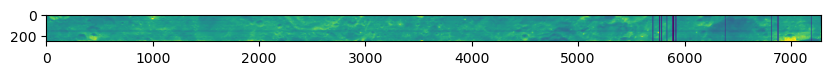

In [4]:
# read in data

# --------------------------------------------- Read in the data --------------------------------------------- #
# - Pick a date - #
date = '20210804'
time = '0341352699_d_img_hw1'

# - Give location of data - #
loc = '/Users/laferrierek/Box Sync/Desktop/Research/Pyroxene_CH2_UndergradProject/Data/'

# - Load in recalibrated data - # --- this has not been filtered, just flat fielded and linearized. 
name = 'ch2_iir_nci_'
subloc = 'CH2/'+name+date+'T'+time+'/data/calibrated/'+date+'/'
filename = 'recalib_'+date+'T'+time+'.npy'
recalib = np.load(loc+subloc+filename)

# Read in Apparent Reflectance (filtered)
App_Reflectance = np.load(loc+'CH2/'+name+date+'T'+time+'/AppRefl_Smoothed20210804.npy')

print("Data loaded:", filename)
print("Data shape:", np.shape(recalib))      #[wavelength, x, y]

# - Load incidence angle data - #
# incidence, phase, hr_angle, sun Azimuth, zenith - all degrees
dirc = loc+'CH2/ch2_iir_nci_'+date+'T'+time+'/'
angles = np.load(dirc+date+'T'+time+'_angles.npy')
incidence = angles[0, :, :]

# Read in calibration data
cal_loc = '/Users/laferrierek/Box Sync/Desktop/Research/Moon_C2/Data/'
# - Read in wavelength - #
wavename = "ch2_iirs_wavelength.csv"
bandnumber, wave_nano, bandwidth = np.loadtxt(cal_loc+wavename, delimiter=',', skiprows=1, unpack=True)
wave = wave_nano/1000

# - Read in Modtran Data - #
mod_loc = '/Users/laferrierek/Box Sync/Desktop/Research/Moon_DI/'
modtran_wave, modtran_rad = np.loadtxt(mod_loc+'Modtran_1nm_4.85um.txt', unpack=True) # units are W/m^2/micron

# - Resample Modtran - #
modtran_resamp = np.interp(wave, modtran_wave, modtran_rad)

IIR_wave, IIR_solarflux =np.loadtxt('/Users/laferrierek/Box Sync/Desktop/Research/Moon_C2/ISSDC/iir/miscellaneous/ch2_iirs_solar_flux.txt', unpack=True)

# - Read in Saturation data - # 
# -- scan 20200522T0854181735_d_img_d18 needs e2g2.
dirc_sat = '/Users/laferrierek/Box Sync/Desktop/Research/Moon_C2/ISSDC/iir/calibration/'+'ch2_iirs_cal_e1g2_saturations_radiance.csv'
bandnumber, maxsr, dynamicrange = np.loadtxt(dirc_sat, delimiter=',', unpack=True)

plt.figure(figsize=(10, 4))
plt.imshow(recalib[10, :, :].T, vmin=0, vmax=5)
plt.show()


In [5]:
# -------------------------- Establish input data and gaussian curve guesses from files-------------------------- #
lowerb = 45; upperb = 115;
print('Wave bounds: %2.1f, %2.1f'%(wave[lowerb], wave[upperb]))

#  -------------------------------------- Calculate Continuum Removed ---------------------------------------- #
bounds = (1.45 < wave) & (wave < 1.55) | (wave > 2.55) & (wave < 2.65)

coef = np.polyfit(wave[bounds], App_Reflectance[:, X, Y][bounds], 1)
line = np.poly1d(coef)
Continuum_Removed = App_Reflectance[:, X, Y] / line(wave) 
fitline = line(wave)
smooth_ConRE = scipy.signal.savgol_filter(Continuum_Removed[lowerb:upperb], window_length=10, polyorder=1)
data_XY = np.vstack((1000*wave[lowerb:upperb], smooth_ConRE)).T
print('Data shape:', np.shape(data_XY))

#  -------------------------------------- Curve fit files ---------------------------------------- #
# Assumed that s and c parameters don't change with new bands. 

FitFile = '/Users/laferrierek/Box Sync/Desktop/Research/Moon_C2/Codes/MGM/Ch2_Inputs.csv'
mstruc = get_model(FitFile) 
datstruc = get_data(data_XY, mstruc['nbands'])

# Fill up arrays with needed ['names']
mstruc, datstruc = fillup(mstruc, datstruc) 
mstruc['FITfile'] = 'Attempt1.csv' # make sure we don't overwrite the input file
mstruc['DATfile'] = 'FILENAME.csv'

# Set initial error limits 
iresl = abs(datstruc['wavel'][1] - datstruc['wavel'][0])
if iresl < 1:
    iresl = 1
ifitres = iresl
isampres = ifitres / iresl  # CALCULATE FIT FREQUENCY
rmsold = rmserr(datstruc['fit'], datstruc['ratio'])

fitflag = 0 # I don't know what this does

Wave bounds: 1.5, 2.7
Data shape: (70, 2)


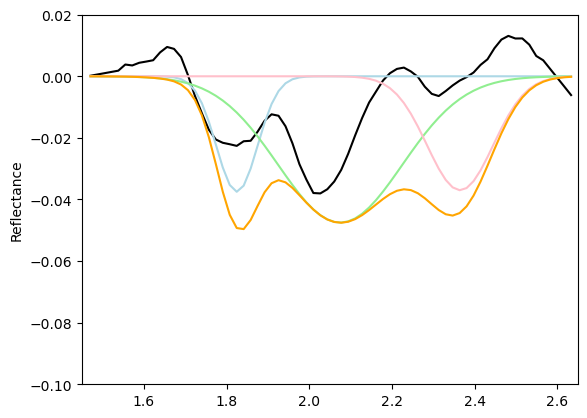

In [6]:
#  -------------------------------- Test by hand solutions ------------------------------- #

def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset
            
def two_gaussians(x, h1, c1, w1, h2, c2, w2, offset):
    return (gaussian(x, h1, c1, w1, offset) +gaussian(x, h2, c2, w2, offset=0)) 

def three_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3, offset):
    return (gaussian(x, h1, c1, w1, offset) +gaussian(x, h2, c2, w2, offset=0)+gaussian(x, h3, c3, w3, offset=0)) 


center0 = mstruc['gcent'][0]/1000
center1 = mstruc['gcent'][1]/1000
center2 = mstruc['gcent'][2]/1000

depth0 = mstruc['gstr'][0]
depth1 = mstruc['gstr'][1]
depth2 = mstruc['gstr'][2]

width0 = mstruc['gwidth'][0]/1000
width1 = mstruc['gwidth'][1]/1000
width2 = mstruc['gwidth'][2]/1000

cropwave = wave[lowerb:upperb]

plt.plot(cropwave, datstruc['ratio'], c='k')
plt.plot(cropwave, gaussian(cropwave, depth0, center0, width0, 0), c='lightblue')
plt.plot(cropwave, gaussian(cropwave, depth1, center1, width1, 0), c='lightgreen')
plt.plot(cropwave, gaussian(cropwave, depth2, center2, width2, 0), c='pink')
plt.plot(cropwave, three_gaussians(cropwave, depth0, center0, width0, depth1, center1, width1, depth2, center2, width2, 0), c='orange')
plt.ylim((-0.1, 0.02))
plt.xlim((1.45, 2.65))
plt.ylabel('Reflectance')
plt.show()





          ======= MGM-FIT 2.0 Python Main Menu =======


   By Jessica Sunshine and Stephen Pratt -- Brown University
   Modified by Kris Laferriere - Purdue University
2024-10-22 09:31:41


   Select: 1-Display Current Parameters
           2-Fit Once
           3-Fit Until
           4-Add/Del/Ch a Parameter
           5-Lock/Unlock a Parameter
           6-Display Routines
           7-Storage Routines (Ref.)
           8-Storage Routines (Log)
           9-Display Parameter Status
          10-Set Fit Resolution
          11-Stop
: 1
2024-10-22T13:33:59   =====  MGM-Fit Parameters  =====

 Straight line removed in Wavelength 0.85 -1e-06

 P0=  8.5000000e-01  P1= -1.0000000e-06  P2=  0.0000000e+00  P3=  0.0000000e+00

3 Absorption Bands

 1  Center=  1.82500000e+03   FWHM=  1.17000000e+02   Str= -3.75000000e-02
 2  Center=  2.07500000e+03   FWHM=  3.53000000e+02   Str= -4.75000000e-02
 3  Center=  2.36500000e+03   FWHM=  1.88000000e+02   Str= -3.70000000e-02


 Current RMS Error 

  314   Old RMS=  5.037428e-03   New RMS=  5.034791e-03   Imp=  2.637351e-06
  315   Old RMS=  5.034791e-03   New RMS=  5.032154e-03   Imp=  2.637072e-06
  316   Old RMS=  5.032154e-03   New RMS=  5.029517e-03   Imp=  2.636828e-06
  317   Old RMS=  5.029517e-03   New RMS=  5.026880e-03   Imp=  2.636620e-06
  318   Old RMS=  5.026880e-03   New RMS=  5.024244e-03   Imp=  2.636448e-06
  319   Old RMS=  5.024244e-03   New RMS=  5.021607e-03   Imp=  2.636309e-06
  320   Old RMS=  5.021607e-03   New RMS=  5.018971e-03   Imp=  2.636204e-06
  321   Old RMS=  5.018971e-03   New RMS=  5.016335e-03   Imp=  2.636132e-06
  322   Old RMS=  5.016335e-03   New RMS=  5.013699e-03   Imp=  2.636093e-06
  323   Old RMS=  5.013699e-03   New RMS=  5.011063e-03   Imp=  2.636086e-06
  324   Old RMS=  5.011063e-03   New RMS=  5.008427e-03   Imp=  2.636110e-06
  325   Old RMS=  5.008427e-03   New RMS=  5.005791e-03   Imp=  2.636165e-06
  326   Old RMS=  5.005791e-03   New RMS=  5.003154e-03   Imp=  2.636251e-06

  616   Old RMS=  4.205327e-03   New RMS=  4.202539e-03   Imp=  2.788013e-06
  617   Old RMS=  4.202539e-03   New RMS=  4.199752e-03   Imp=  2.786511e-06
  618   Old RMS=  4.199752e-03   New RMS=  4.196967e-03   Imp=  2.784986e-06
  619   Old RMS=  4.196967e-03   New RMS=  4.194184e-03   Imp=  2.783435e-06
  620   Old RMS=  4.194184e-03   New RMS=  4.191402e-03   Imp=  2.781861e-06
  621   Old RMS=  4.191402e-03   New RMS=  4.188622e-03   Imp=  2.780261e-06
  622   Old RMS=  4.188622e-03   New RMS=  4.185843e-03   Imp=  2.778637e-06
  623   Old RMS=  4.185843e-03   New RMS=  4.183066e-03   Imp=  2.776989e-06
  624   Old RMS=  4.183066e-03   New RMS=  4.180291e-03   Imp=  2.775316e-06
  625   Old RMS=  4.180291e-03   New RMS=  4.177517e-03   Imp=  2.773618e-06
  626   Old RMS=  4.177517e-03   New RMS=  4.174745e-03   Imp=  2.771896e-06
  627   Old RMS=  4.174745e-03   New RMS=  4.171975e-03   Imp=  2.770148e-06
  628   Old RMS=  4.171975e-03   New RMS=  4.169207e-03   Imp=  2.768376e-06

  945   Old RMS=  3.495484e-03   New RMS=  3.494198e-03   Imp=  1.286118e-06
  946   Old RMS=  3.494198e-03   New RMS=  3.492918e-03   Imp=  1.280677e-06
  947   Old RMS=  3.492918e-03   New RMS=  3.491642e-03   Imp=  1.275245e-06
  948   Old RMS=  3.491642e-03   New RMS=  3.490373e-03   Imp=  1.269824e-06
  949   Old RMS=  3.490373e-03   New RMS=  3.489108e-03   Imp=  1.264414e-06
  950   Old RMS=  3.489108e-03   New RMS=  3.487849e-03   Imp=  1.259014e-06
  951   Old RMS=  3.487849e-03   New RMS=  3.486596e-03   Imp=  1.253625e-06
  952   Old RMS=  3.486596e-03   New RMS=  3.485347e-03   Imp=  1.248246e-06
  953   Old RMS=  3.485347e-03   New RMS=  3.484104e-03   Imp=  1.242879e-06
  954   Old RMS=  3.484104e-03   New RMS=  3.482867e-03   Imp=  1.237522e-06
  955   Old RMS=  3.482867e-03   New RMS=  3.481635e-03   Imp=  1.232177e-06
  956   Old RMS=  3.481635e-03   New RMS=  3.480408e-03   Imp=  1.226843e-06
  957   Old RMS=  3.480408e-03   New RMS=  3.479186e-03   Imp=  1.221520e-06

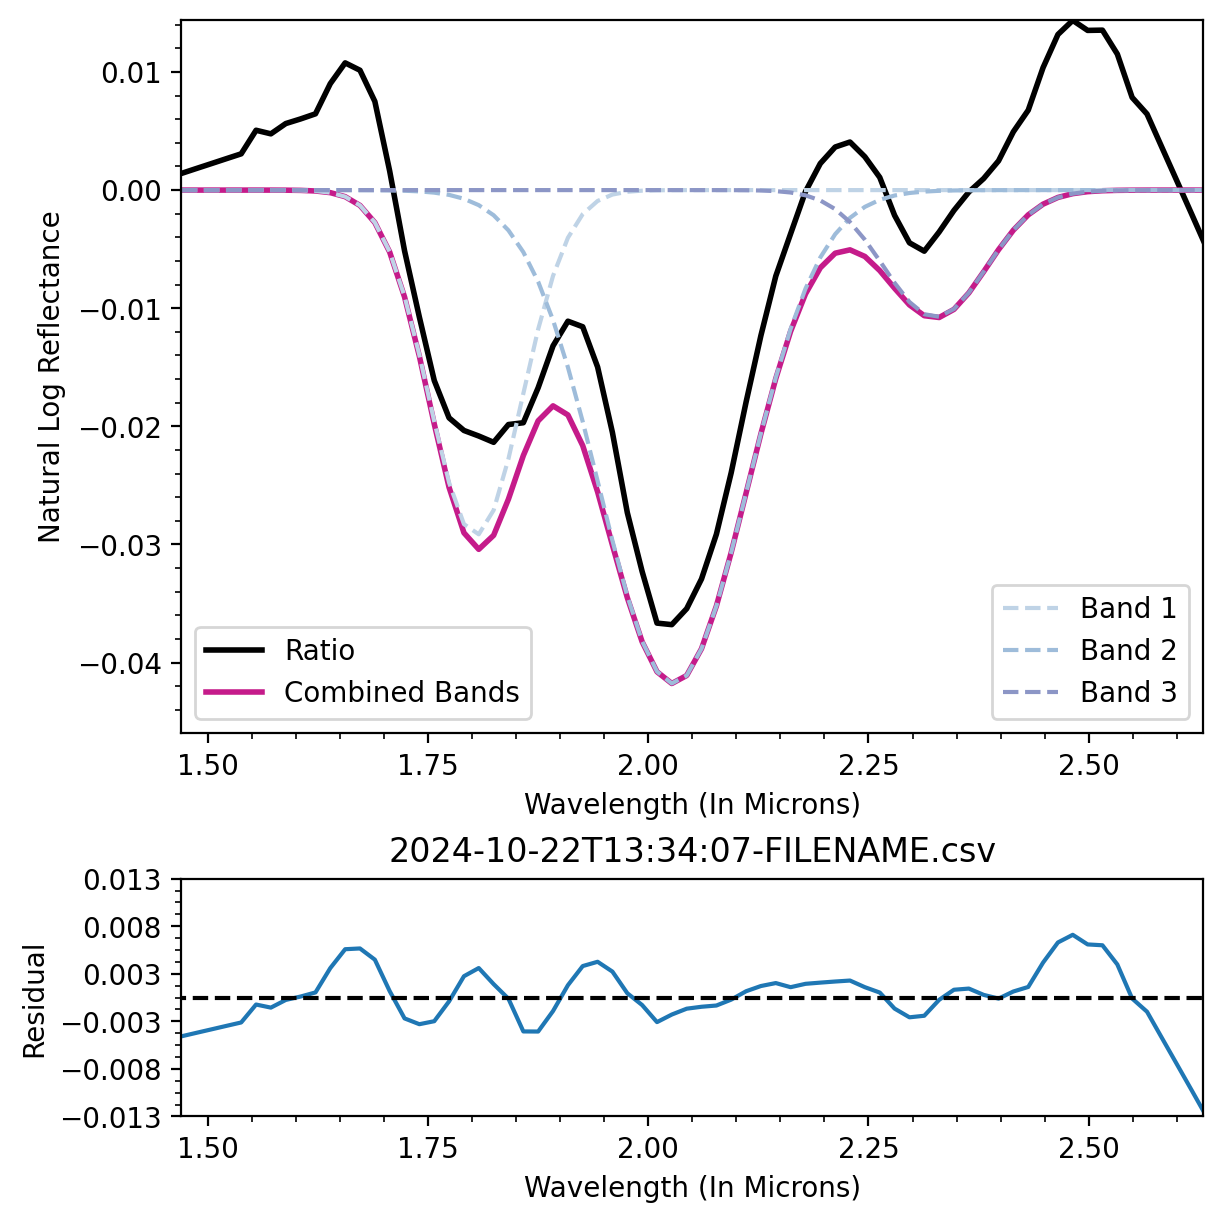

2024-10-22 09:34:07   =====  MGM-FIT  Display Routines =====
   Select: 1-Display Graph in Wavelength Space
           2-Send to PDF
           3-Exit Display
: 3



          ======= MGM-FIT 2.0 Python Main Menu =======


   By Jessica Sunshine and Stephen Pratt -- Brown University
   Modified by Kris Laferriere - Purdue University
2024-10-22 09:35:01


   Select: 1-Display Current Parameters
           2-Fit Once
           3-Fit Until
           4-Add/Del/Ch a Parameter
           5-Lock/Unlock a Parameter
           6-Display Routines
           7-Storage Routines (Ref.)
           8-Storage Routines (Log)
           9-Display Parameter Status
          10-Set Fit Resolution
          11-Stop
: 11


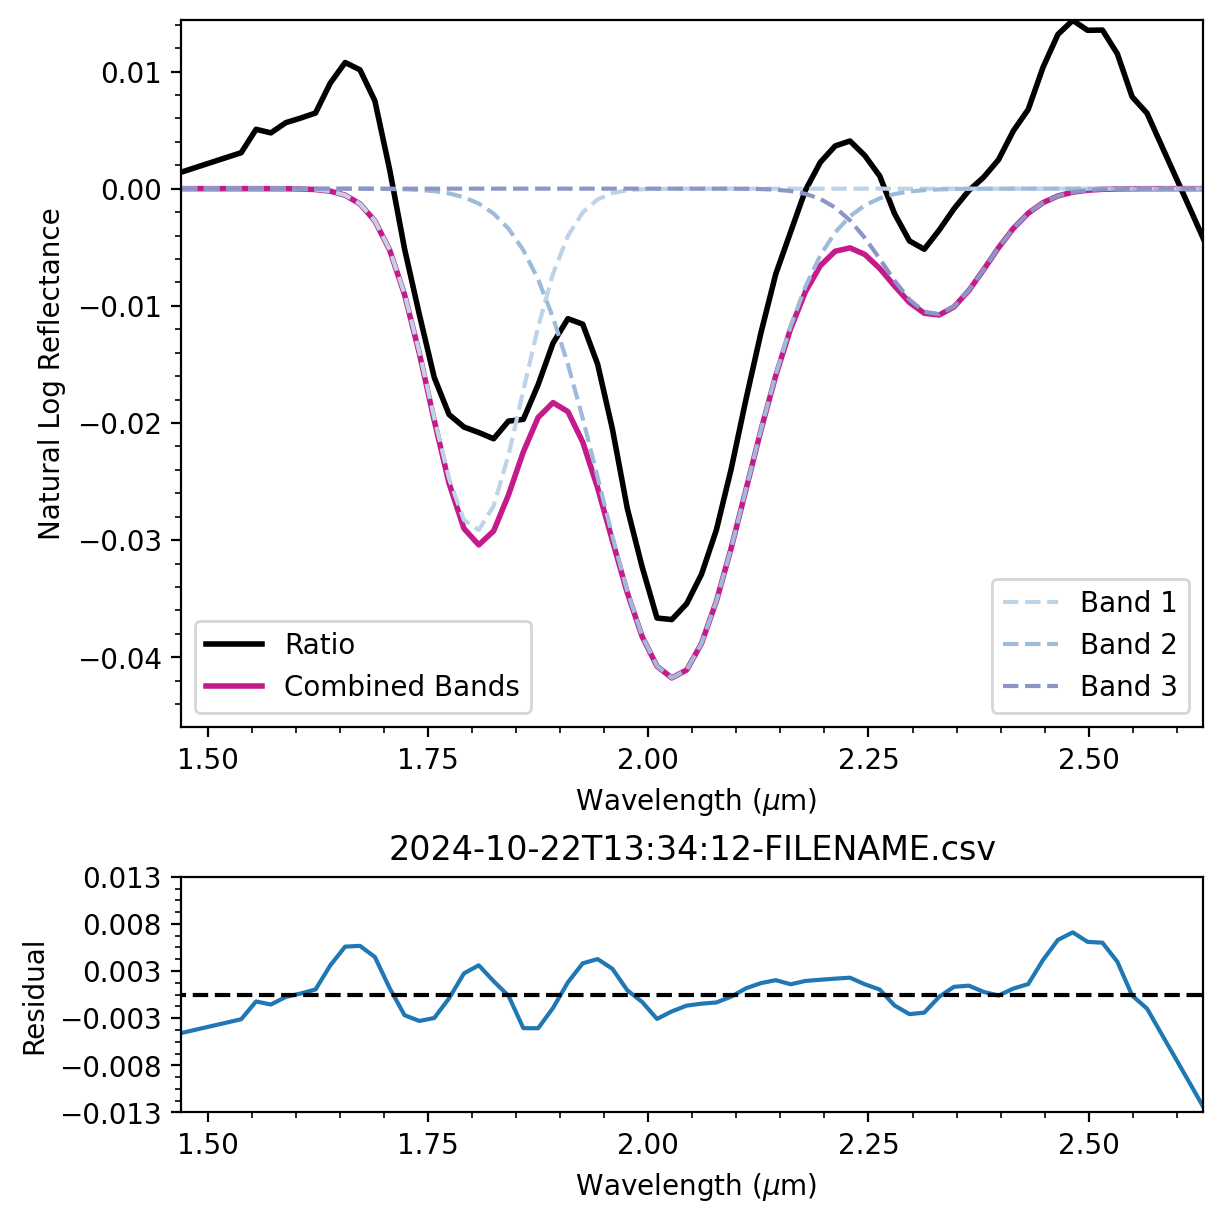

In [7]:
DoAgain = True
while DoAgain:
    IDATE = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('\n' * 2)
    print('          ======= MGM-FIT 2.0 Python Main Menu =======')
    print('\n')
    print('   By Jessica Sunshine and Stephen Pratt -- Brown University')
    print('   Modified by Kris Laferriere - Purdue University')
    print(IDATE)
    print('\n')
    print('   Select: 1-Display Current Parameters')
    print('           2-Fit Once')
    print('           3-Fit Until')
    print('           4-Add/Del/Ch a Parameter')
    print('           5-Lock/Unlock a Parameter')
    print('           6-Display Routines')
    print('           7-Storage Routines (Ref.)')
    print('           8-Storage Routines (Log)')
    print('           9-Display Parameter Status')
    print('          10-Set Fit Resolution')
    print('          11-Stop')

    choice = input(': ')
    if len(choice) == 0:
        choice = 11
    else:
        choice = int(choice)

    if choice == 1:
        # List current parameters
        listpar(mstruc, datstruc)
    elif choice == 2:
        # CALL FITTING ONCE
        mstruc, datstruc = stocfit(mstruc, datstruc, isampres, 0)
        fitflag = 1
    elif choice == 3:
        # CALL FITTING UNTIL
        mstruc, datstruc = stocfit(mstruc, datstruc, isampres, 1)
        fitflag = 1
    elif choice == 4:
        # CHANGE/DEL/ADD A BAND
        mstruc, datstruc = chpar(mstruc, datstruc)
    elif choice == 5:
        # LOCK/UNLOCK PARAMETERS
        mstruc = lockup(mstruc)
    elif choice == 6:
        # DISPLAY PLOT
        display_routine(mstruc, datstruc)
    elif choice == 7:
        # STORING PARAMETERS (Ref)
        storcurv1(mstruc, datstruc)
    elif choice == 8:
        # STORING PARAMETERS (Log)
        storcurv2(mstruc, datstruc)
    elif choice == 9:
        # LISTING PARAMETERS
        liststat(mstruc)
    elif choice == 10:
        # SETTING FIT RESOLUTION
        iresl = abs(datstruc['wavel'][1] - datstruc['wavel'][0])
        print(f'Spectrum Resolution {iresl} Nm. Fitting Resolution {ifitres} Nm.')
        ifitres = float(input('Enter Fitting Resolution in Nanometers: '))
        if ifitres < 1:
            ifitres = iresl
        isampres = int(ifitres / iresl)  # CALCULATE FIT FREQUENCY
        if isampres < 1:
            isampres = 1
    elif choice == 11:
        # Quit
        if fitflag:
            dumpar(mstruc, datstruc)
        DoAgain = False